In [8]:
import torch
import torchtext
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from perceiver_pytorch import Perceiver
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import itertools
from torch.utils.tensorboard import SummaryWriter
import os
from tqdm.notebook import tqdm
from datetime import datetime
from babi_joint import BabiDataset, pad_collate
from torch.utils.data.dataset import Dataset
from glob import glob
from perceiver_pytorch import PerceiverIObAbI
import time

In [14]:
model = PerceiverIObAbI(
    num_tokens=179,
    context_max_seq_len=70*13,
    question_max_seq_len=13,
    dim = 16,                    # dimension of sequence to be encoded
    queries_dim = 179,            # dimension of decoder queries
#     logits_dim = 50,            # dimension of final logits
    depth = 3,                   # depth of net
    num_latents = 13,           # number of latents, or induced set points, or centroids. different papers giving it different names
    latent_dim = 16,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention. paper said 1
    latent_heads = 8,            # number of heads for latent self attention, 8
    cross_dim_head = 32,         # number of dimensions per cross attention head
    latent_dim_head = 32,        # number of dimensions per latent self attention head
    weight_tie_layers = True,   # whether to weight tie layers (optional, as indicated in the diagram)
    self_per_cross_attn = 1,     # number of self attention blocks per cross attention
    learn_latents=False
)

model_name = 'perceiverIO_bAbi'

In [3]:
batch_size=128
max_epochs = 150

babi_dataset = BabiDataset(ds_path='/home/gabriel/Documents/datasets/bAbi/en/qa{}_*', 
                           vocab_path='/home/gabriel/Documents/datasets/bAbi/en/babi{}_vocab.pkl')
vocab_size = len(babi_dataset.QA.VOCAB)
print('len(babi_dataset) train', len(babi_dataset))
print('vocab_size', vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
torch.backends.cudnn.benchmark = True
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
val_loss_min = float('inf')

writer = SummaryWriter()
if not os.path.isdir(f'checkpoints/{model_name}'):
    os.mkdir(f'checkpoints/{model_name}')
now = datetime.now().strftime("%d_%m_%Y__%H_%M_%S")

for epoch in range(max_epochs):
    train_loss = 0.0
    val_loss = 0.0
    loss_sum = 0
    loss_count = 0
    model.train()
    babi_dataset.set_mode('train')
    train_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate
    )
    
    for batch_idx, data in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{max_epochs}")):
        optimizer.zero_grad()

        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)
        
        logits = torch.squeeze(model(contexts, questions))
        loss = criterion(logits, answers)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        writer.add_scalars("losses_step", {"train_loss": loss.item() / contexts.size(0)}, epoch * len(train_loader) + batch_idx)
    
    train_loss = train_loss / len(train_loader.dataset)
    writer.add_scalars("losses_epoch", {"train_loss": train_loss}, epoch)
    train_loader_len = len(train_loader)
    
    model.eval()
    babi_dataset.set_mode('valid')
    val_loader = DataLoader(
        babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
    )
    
    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
        
            contexts, questions, answers, tasks = data
            contexts = contexts.long().to(device)
            questions = questions.long().to(device)
            answers = answers.to(device)
        
            logits = torch.squeeze(model(contexts, questions))
            loss = criterion(logits, answers)
            val_loss += loss.item()

    val_loss = val_loss / len(val_loader.dataset)
    writer.add_scalars("losses_step", {"val_loss": val_loss}, (epoch + 1) * train_loader_len - 1)    
    writer.add_scalars("losses_epoch", {"val_loss": val_loss}, epoch)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        val_loss
    ))
    
    checkpoint = {
        'epoch': epoch + 1,
        'valid_loss_min': val_loss,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    
    torch.save(checkpoint, f'checkpoints/{model_name}/checkpoint_{now}.pt')
    if val_loss <= val_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_min,val_loss))
        torch.save(checkpoint, f'checkpoints/{model_name}/best_checkpoint_{now}.pt')
        val_loss_min = val_loss

len(babi_dataset) train 180000
vocab_size 179
cuda:0


Epoch 1/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 2.826796 	Validation Loss: 1.770996
Validation loss decreased (inf --> 1.770996).  Saving model ...


Epoch 2/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 1.575286 	Validation Loss: 1.472143
Validation loss decreased (1.770996 --> 1.472143).  Saving model ...


Epoch 3/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 1.441292 	Validation Loss: 1.398375
Validation loss decreased (1.472143 --> 1.398375).  Saving model ...


Epoch 4/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.390229 	Validation Loss: 1.380657
Validation loss decreased (1.398375 --> 1.380657).  Saving model ...


Epoch 5/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 1.346690 	Validation Loss: 1.316417
Validation loss decreased (1.380657 --> 1.316417).  Saving model ...


Epoch 6/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 1.303422 	Validation Loss: 1.272964
Validation loss decreased (1.316417 --> 1.272964).  Saving model ...


Epoch 7/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.268373 	Validation Loss: 1.252846
Validation loss decreased (1.272964 --> 1.252846).  Saving model ...


Epoch 8/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 1.249264 	Validation Loss: 1.233740
Validation loss decreased (1.252846 --> 1.233740).  Saving model ...


Epoch 9/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 1.235762 	Validation Loss: 1.224058
Validation loss decreased (1.233740 --> 1.224058).  Saving model ...


Epoch 10/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 1.222232 	Validation Loss: 1.206848
Validation loss decreased (1.224058 --> 1.206848).  Saving model ...


Epoch 11/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 1.208956 	Validation Loss: 1.195825
Validation loss decreased (1.206848 --> 1.195825).  Saving model ...


Epoch 12/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 1.187055 	Validation Loss: 1.169228
Validation loss decreased (1.195825 --> 1.169228).  Saving model ...


Epoch 13/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 1.161122 	Validation Loss: 1.154848
Validation loss decreased (1.169228 --> 1.154848).  Saving model ...


Epoch 14/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 1.136228 	Validation Loss: 1.103039
Validation loss decreased (1.154848 --> 1.103039).  Saving model ...


Epoch 15/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 1.096621 	Validation Loss: 1.067929
Validation loss decreased (1.103039 --> 1.067929).  Saving model ...


Epoch 16/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 1.071783 	Validation Loss: 1.055472
Validation loss decreased (1.067929 --> 1.055472).  Saving model ...


Epoch 17/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 1.054819 	Validation Loss: 1.032752
Validation loss decreased (1.055472 --> 1.032752).  Saving model ...


Epoch 18/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 1.040570 	Validation Loss: 1.024034
Validation loss decreased (1.032752 --> 1.024034).  Saving model ...


Epoch 19/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 1.028358 	Validation Loss: 1.015686
Validation loss decreased (1.024034 --> 1.015686).  Saving model ...


Epoch 20/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 1.019034 	Validation Loss: 1.000223
Validation loss decreased (1.015686 --> 1.000223).  Saving model ...


Epoch 21/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 1.008960 	Validation Loss: 1.000889


Epoch 22/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 1.001099 	Validation Loss: 0.987821
Validation loss decreased (1.000223 --> 0.987821).  Saving model ...


Epoch 23/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.994048 	Validation Loss: 0.978519
Validation loss decreased (0.987821 --> 0.978519).  Saving model ...


Epoch 24/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.989007 	Validation Loss: 0.978686


Epoch 25/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.983445 	Validation Loss: 0.967965
Validation loss decreased (0.978519 --> 0.967965).  Saving model ...


Epoch 26/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.979251 	Validation Loss: 0.965015
Validation loss decreased (0.967965 --> 0.965015).  Saving model ...


Epoch 27/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.973570 	Validation Loss: 0.967132


Epoch 28/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.969033 	Validation Loss: 0.963242
Validation loss decreased (0.965015 --> 0.963242).  Saving model ...


Epoch 29/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.964839 	Validation Loss: 0.953310
Validation loss decreased (0.963242 --> 0.953310).  Saving model ...


Epoch 30/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.961061 	Validation Loss: 0.950284
Validation loss decreased (0.953310 --> 0.950284).  Saving model ...


Epoch 31/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.956335 	Validation Loss: 0.950103
Validation loss decreased (0.950284 --> 0.950103).  Saving model ...


Epoch 32/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.953093 	Validation Loss: 0.951912


Epoch 33/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.950043 	Validation Loss: 0.943498
Validation loss decreased (0.950103 --> 0.943498).  Saving model ...


Epoch 34/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.945149 	Validation Loss: 0.948486


Epoch 35/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.942271 	Validation Loss: 0.940840
Validation loss decreased (0.943498 --> 0.940840).  Saving model ...


Epoch 36/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.938595 	Validation Loss: 0.943111


Epoch 37/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.935810 	Validation Loss: 0.933269
Validation loss decreased (0.940840 --> 0.933269).  Saving model ...


Epoch 38/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.933784 	Validation Loss: 0.945508


Epoch 39/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.929489 	Validation Loss: 0.924258
Validation loss decreased (0.933269 --> 0.924258).  Saving model ...


Epoch 40/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.926898 	Validation Loss: 0.932022


Epoch 41/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.923935 	Validation Loss: 0.928210


Epoch 42/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.920798 	Validation Loss: 0.922254
Validation loss decreased (0.924258 --> 0.922254).  Saving model ...


Epoch 43/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.917735 	Validation Loss: 0.919608
Validation loss decreased (0.922254 --> 0.919608).  Saving model ...


Epoch 44/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.915690 	Validation Loss: 0.920429


Epoch 45/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.912163 	Validation Loss: 0.909429
Validation loss decreased (0.919608 --> 0.909429).  Saving model ...


Epoch 46/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.909479 	Validation Loss: 0.909461


Epoch 47/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.906910 	Validation Loss: 0.909420
Validation loss decreased (0.909429 --> 0.909420).  Saving model ...


Epoch 48/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.903644 	Validation Loss: 0.906181
Validation loss decreased (0.909420 --> 0.906181).  Saving model ...


Epoch 49/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.900342 	Validation Loss: 0.905936
Validation loss decreased (0.906181 --> 0.905936).  Saving model ...


Epoch 50/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 50 	Training Loss: 0.897212 	Validation Loss: 0.896665
Validation loss decreased (0.905936 --> 0.896665).  Saving model ...


Epoch 51/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 51 	Training Loss: 0.893404 	Validation Loss: 0.905286


Epoch 52/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 52 	Training Loss: 0.889530 	Validation Loss: 0.894506
Validation loss decreased (0.896665 --> 0.894506).  Saving model ...


Epoch 53/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 53 	Training Loss: 0.885641 	Validation Loss: 0.894899


Epoch 54/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 54 	Training Loss: 0.881358 	Validation Loss: 0.881826
Validation loss decreased (0.894506 --> 0.881826).  Saving model ...


Epoch 55/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 55 	Training Loss: 0.878654 	Validation Loss: 0.877955
Validation loss decreased (0.881826 --> 0.877955).  Saving model ...


Epoch 56/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 56 	Training Loss: 0.874441 	Validation Loss: 0.885764


Epoch 57/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 57 	Training Loss: 0.870334 	Validation Loss: 0.870672
Validation loss decreased (0.877955 --> 0.870672).  Saving model ...


Epoch 58/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 58 	Training Loss: 0.867829 	Validation Loss: 0.867798
Validation loss decreased (0.870672 --> 0.867798).  Saving model ...


Epoch 59/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 59 	Training Loss: 0.864603 	Validation Loss: 0.878955


Epoch 60/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 60 	Training Loss: 0.861405 	Validation Loss: 0.870782


Epoch 61/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 61 	Training Loss: 0.859844 	Validation Loss: 0.872435


Epoch 62/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 62 	Training Loss: 0.856567 	Validation Loss: 0.867287
Validation loss decreased (0.867798 --> 0.867287).  Saving model ...


Epoch 63/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 63 	Training Loss: 0.854940 	Validation Loss: 0.860009
Validation loss decreased (0.867287 --> 0.860009).  Saving model ...


Epoch 64/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 64 	Training Loss: 0.853033 	Validation Loss: 0.856567
Validation loss decreased (0.860009 --> 0.856567).  Saving model ...


Epoch 65/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 65 	Training Loss: 0.850755 	Validation Loss: 0.864124


Epoch 66/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 66 	Training Loss: 0.849207 	Validation Loss: 0.857691


Epoch 67/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 67 	Training Loss: 0.847777 	Validation Loss: 0.858384


Epoch 68/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 68 	Training Loss: 0.846212 	Validation Loss: 0.853423
Validation loss decreased (0.856567 --> 0.853423).  Saving model ...


Epoch 69/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 69 	Training Loss: 0.844534 	Validation Loss: 0.858499


Epoch 70/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 70 	Training Loss: 0.842881 	Validation Loss: 0.851635
Validation loss decreased (0.853423 --> 0.851635).  Saving model ...


Epoch 71/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 71 	Training Loss: 0.841293 	Validation Loss: 0.856254


Epoch 72/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 72 	Training Loss: 0.839794 	Validation Loss: 0.858117


Epoch 73/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 73 	Training Loss: 0.838080 	Validation Loss: 0.858935


Epoch 74/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 74 	Training Loss: 0.837400 	Validation Loss: 0.850661
Validation loss decreased (0.851635 --> 0.850661).  Saving model ...


Epoch 75/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 75 	Training Loss: 0.835504 	Validation Loss: 0.848397
Validation loss decreased (0.850661 --> 0.848397).  Saving model ...


Epoch 76/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 76 	Training Loss: 0.834939 	Validation Loss: 0.846357
Validation loss decreased (0.848397 --> 0.846357).  Saving model ...


Epoch 77/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 77 	Training Loss: 0.833538 	Validation Loss: 0.844227
Validation loss decreased (0.846357 --> 0.844227).  Saving model ...


Epoch 78/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 78 	Training Loss: 0.832162 	Validation Loss: 0.843432
Validation loss decreased (0.844227 --> 0.843432).  Saving model ...


Epoch 79/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 79 	Training Loss: 0.830873 	Validation Loss: 0.842180
Validation loss decreased (0.843432 --> 0.842180).  Saving model ...


Epoch 80/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 80 	Training Loss: 0.830113 	Validation Loss: 0.840822
Validation loss decreased (0.842180 --> 0.840822).  Saving model ...


Epoch 81/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 81 	Training Loss: 0.828472 	Validation Loss: 0.839199
Validation loss decreased (0.840822 --> 0.839199).  Saving model ...


Epoch 82/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 82 	Training Loss: 0.827451 	Validation Loss: 0.847545


Epoch 83/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 83 	Training Loss: 0.826388 	Validation Loss: 0.847156


Epoch 84/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 84 	Training Loss: 0.827695 	Validation Loss: 0.834914
Validation loss decreased (0.839199 --> 0.834914).  Saving model ...


Epoch 85/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 85 	Training Loss: 0.825312 	Validation Loss: 0.840421


Epoch 86/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 86 	Training Loss: 0.822675 	Validation Loss: 0.834743
Validation loss decreased (0.834914 --> 0.834743).  Saving model ...


Epoch 87/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 87 	Training Loss: 0.822850 	Validation Loss: 0.843183


Epoch 88/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 88 	Training Loss: 0.820899 	Validation Loss: 0.839221


Epoch 89/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 89 	Training Loss: 0.819642 	Validation Loss: 0.838026


Epoch 90/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 90 	Training Loss: 0.818158 	Validation Loss: 0.841138


Epoch 91/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 91 	Training Loss: 0.817730 	Validation Loss: 0.833008
Validation loss decreased (0.834743 --> 0.833008).  Saving model ...


Epoch 92/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 92 	Training Loss: 0.816542 	Validation Loss: 0.830508
Validation loss decreased (0.833008 --> 0.830508).  Saving model ...


Epoch 93/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 93 	Training Loss: 0.815064 	Validation Loss: 0.831855


Epoch 94/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 94 	Training Loss: 0.813956 	Validation Loss: 0.831763


Epoch 95/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 95 	Training Loss: 0.812846 	Validation Loss: 0.825609
Validation loss decreased (0.830508 --> 0.825609).  Saving model ...


Epoch 96/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 96 	Training Loss: 0.811797 	Validation Loss: 0.828072


Epoch 97/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 97 	Training Loss: 0.810474 	Validation Loss: 0.824858
Validation loss decreased (0.825609 --> 0.824858).  Saving model ...


Epoch 98/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 98 	Training Loss: 0.809704 	Validation Loss: 0.832104


Epoch 99/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 99 	Training Loss: 0.808155 	Validation Loss: 0.830046


Epoch 100/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 100 	Training Loss: 0.807649 	Validation Loss: 0.825536


Epoch 101/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 101 	Training Loss: 0.806381 	Validation Loss: 0.825000


Epoch 102/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 102 	Training Loss: 0.805250 	Validation Loss: 0.819164
Validation loss decreased (0.824858 --> 0.819164).  Saving model ...


Epoch 103/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 103 	Training Loss: 0.803794 	Validation Loss: 0.819827


Epoch 104/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 104 	Training Loss: 0.801800 	Validation Loss: 0.822894


Epoch 105/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 105 	Training Loss: 0.800105 	Validation Loss: 0.818009
Validation loss decreased (0.819164 --> 0.818009).  Saving model ...


Epoch 106/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 106 	Training Loss: 0.797497 	Validation Loss: 0.817499
Validation loss decreased (0.818009 --> 0.817499).  Saving model ...


Epoch 107/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 107 	Training Loss: 0.796348 	Validation Loss: 0.811704
Validation loss decreased (0.817499 --> 0.811704).  Saving model ...


Epoch 108/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 108 	Training Loss: 0.794599 	Validation Loss: 0.815553


Epoch 109/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 109 	Training Loss: 0.792962 	Validation Loss: 0.810398
Validation loss decreased (0.811704 --> 0.810398).  Saving model ...


Epoch 110/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 110 	Training Loss: 0.791682 	Validation Loss: 0.811489


Epoch 111/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 111 	Training Loss: 0.790119 	Validation Loss: 0.812069


Epoch 112/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 112 	Training Loss: 0.789145 	Validation Loss: 0.808133
Validation loss decreased (0.810398 --> 0.808133).  Saving model ...


Epoch 113/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 113 	Training Loss: 0.787682 	Validation Loss: 0.807995
Validation loss decreased (0.808133 --> 0.807995).  Saving model ...


Epoch 114/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 114 	Training Loss: 0.786912 	Validation Loss: 0.805874
Validation loss decreased (0.807995 --> 0.805874).  Saving model ...


Epoch 115/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 115 	Training Loss: 0.785771 	Validation Loss: 0.805628
Validation loss decreased (0.805874 --> 0.805628).  Saving model ...


Epoch 116/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 116 	Training Loss: 0.784637 	Validation Loss: 0.810881


Epoch 117/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 117 	Training Loss: 0.784426 	Validation Loss: 0.802305
Validation loss decreased (0.805628 --> 0.802305).  Saving model ...


Epoch 118/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 118 	Training Loss: 0.782628 	Validation Loss: 0.804492


Epoch 119/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 119 	Training Loss: 0.781618 	Validation Loss: 0.804456


Epoch 120/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 120 	Training Loss: 0.781002 	Validation Loss: 0.799765
Validation loss decreased (0.802305 --> 0.799765).  Saving model ...


Epoch 121/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 121 	Training Loss: 0.780101 	Validation Loss: 0.806370


Epoch 122/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 122 	Training Loss: 0.779152 	Validation Loss: 0.801511


Epoch 123/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 123 	Training Loss: 0.777718 	Validation Loss: 0.804763


Epoch 124/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 124 	Training Loss: 0.777913 	Validation Loss: 0.796416
Validation loss decreased (0.799765 --> 0.796416).  Saving model ...


Epoch 125/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 125 	Training Loss: 0.776770 	Validation Loss: 0.796022
Validation loss decreased (0.796416 --> 0.796022).  Saving model ...


Epoch 126/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 126 	Training Loss: 0.775726 	Validation Loss: 0.797855


Epoch 127/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 127 	Training Loss: 0.774599 	Validation Loss: 0.802795


Epoch 128/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 128 	Training Loss: 0.774792 	Validation Loss: 0.796480


Epoch 129/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 129 	Training Loss: 0.773407 	Validation Loss: 0.799869


Epoch 130/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 130 	Training Loss: 0.772605 	Validation Loss: 0.797888


Epoch 131/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 131 	Training Loss: 0.771637 	Validation Loss: 0.793477
Validation loss decreased (0.796022 --> 0.793477).  Saving model ...


Epoch 132/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 132 	Training Loss: 0.771299 	Validation Loss: 0.795383


Epoch 133/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 133 	Training Loss: 0.770935 	Validation Loss: 0.799581


Epoch 134/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 134 	Training Loss: 0.770695 	Validation Loss: 0.791874
Validation loss decreased (0.793477 --> 0.791874).  Saving model ...


Epoch 135/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 135 	Training Loss: 0.768976 	Validation Loss: 0.791738
Validation loss decreased (0.791874 --> 0.791738).  Saving model ...


Epoch 136/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 136 	Training Loss: 0.769227 	Validation Loss: 0.798131


Epoch 137/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 137 	Training Loss: 0.768465 	Validation Loss: 0.791711
Validation loss decreased (0.791738 --> 0.791711).  Saving model ...


Epoch 138/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 138 	Training Loss: 0.767340 	Validation Loss: 0.798665


Epoch 139/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 139 	Training Loss: 0.768123 	Validation Loss: 0.789010
Validation loss decreased (0.791711 --> 0.789010).  Saving model ...


Epoch 140/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 140 	Training Loss: 0.765357 	Validation Loss: 0.793375


Epoch 141/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 141 	Training Loss: 0.765243 	Validation Loss: 0.796574


Epoch 142/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 142 	Training Loss: 0.763958 	Validation Loss: 0.796729


Epoch 143/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 143 	Training Loss: 0.763859 	Validation Loss: 0.791435


Epoch 144/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 144 	Training Loss: 0.763486 	Validation Loss: 0.788947
Validation loss decreased (0.789010 --> 0.788947).  Saving model ...


Epoch 145/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 145 	Training Loss: 0.762321 	Validation Loss: 0.797826


Epoch 146/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 146 	Training Loss: 0.762678 	Validation Loss: 0.795439


Epoch 147/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 147 	Training Loss: 0.761113 	Validation Loss: 0.790100


Epoch 148/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 148 	Training Loss: 0.760434 	Validation Loss: 0.790271


Epoch 149/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 149 	Training Loss: 0.759386 	Validation Loss: 0.786196
Validation loss decreased (0.788947 --> 0.786196).  Saving model ...


Epoch 150/150:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch: 150 	Training Loss: 0.759039 	Validation Loss: 0.788381


cuda:0


Inference:   0%|          | 0/157 [00:00<?, ?it/s]

/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gabriel/miniconda3/

0.64035
                     precision    recall  f1-score   support

              apple       0.80      0.74      0.77       341
     apple,football       0.00      0.00      0.00        11
apple,football,milk       0.00      0.00      0.00         1
         apple,milk       0.00      0.00      0.00        10
           bathroom       0.63      0.63      0.63      1195
            bedroom       0.64      0.61      0.63      1437
               bill       0.62      0.55      0.59       164
              bored       1.00      1.00      1.00       159
                cat       0.60      0.53      0.56       213
             cinema       0.43      0.44      0.44       171
                e,e       0.25      0.04      0.06        81
                e,n       0.08      0.06      0.07        88
                e,s       0.00      0.00      0.00        79
           football       0.73      0.75      0.74       281
     football,apple       0.25      0.06      0.09        18
football,apple,

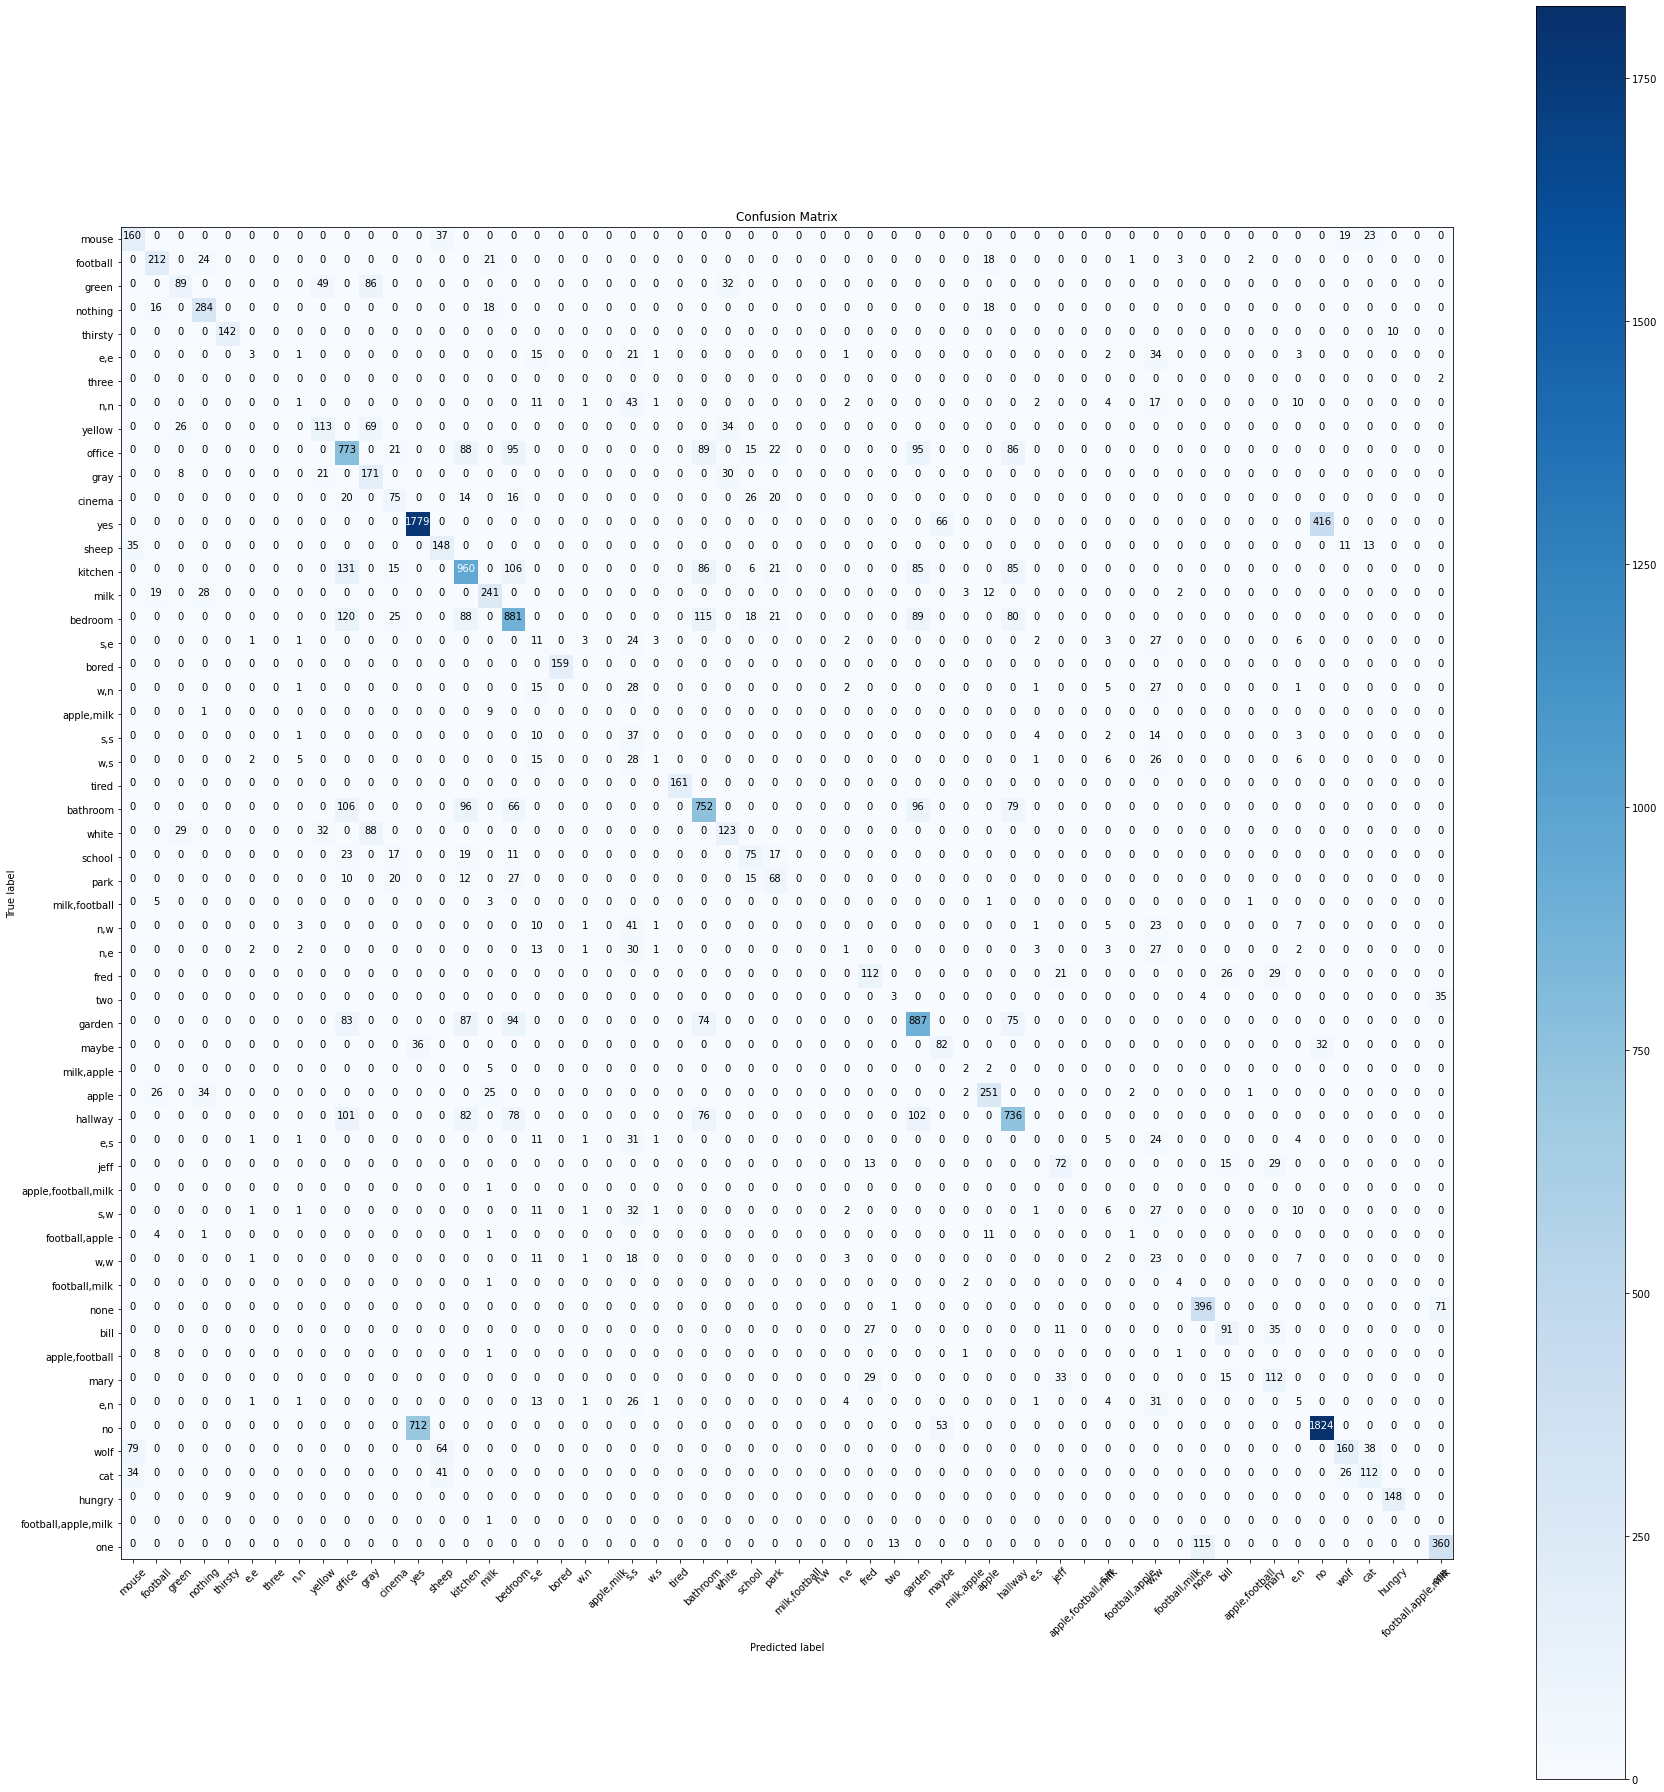

2.5210182666778564


In [17]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)
model.to(device)
checkpoint_name = 'checkpoints/perceiverIO_bAbi/best_checkpoint_26_08_2021__01_15_06.pt' # f'checkpoints/{model_name}/best_checkpoint_{now}.pt'
checkpoint = torch.load(checkpoint_name)
model.load_state_dict(checkpoint['state_dict'])
model.eval()
m = nn.Softmax(dim=1)

babi_dataset.set_mode('test')
test_loader = DataLoader(
    babi_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate
)

y_pred_extended = []
y_true_extended = []
y_pred_task = [[] for _ in range(20)]
y_true_task = [[] for _ in range(20)]

start = time.time()
with torch.no_grad():
    for batch_idx, data in enumerate(tqdm(test_loader, desc=f"Inference")):
        contexts, questions, answers, tasks = data
        contexts = contexts.long().to(device)
        questions = questions.long().to(device)
        answers = answers.to(device)

        logits = torch.squeeze(model(contexts, questions)).cpu()
        # We consider a task successfully passed if ≥ 95% accuracy is obtained.
        y_pred = m(logits)
        y_pred = np.argmax(y_pred, axis=1)
        y_pred = [babi_dataset.QA.IVOCAB[int(i)] for i in y_pred]
        y_true = [babi_dataset.QA.IVOCAB[int(i)] for i in answers.cpu()]
        y_pred_extended.extend(y_pred)
        y_true_extended.extend(y_true)
        for i in range(len(y_pred)):
            y_pred_task[int(tasks[i]) - 1].append(y_pred[i])
            y_true_task[int(tasks[i]) - 1].append(y_true[i])
end = time.time()

        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize=(25,25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

accuracy = accuracy_score(y_pred_extended, y_true_extended)
cr = classification_report(y_true_extended, y_pred_extended)
print(accuracy)
print(cr)
task_acc = []
passed_tasks = []
for i in range(20):
    task_acc.append(accuracy_score(y_pred_task[i], y_true_task[i]))
    passed_tasks.append(1 if task_acc[i] >= 0.95 else 0)
print(task_acc)
print('passed_tasks:', passed_tasks)
print('no. passed_tasks:', sum(passed_tasks))
labels = list(set(y_true_extended).intersection(set(y_true_extended)))
cnf_matrix = confusion_matrix(y_true_extended, y_pred_extended, labels)
# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels, title = ('Confusion Matrix'))
plt.show()
print(end-start)

In [23]:
# from thop import profile
# from thop import clever_format

# macs, params = profile(model, inputs=(
#                         torch.randint(1, size=(1, 910)).type(torch.LongTensor).to(device), 
#                         torch.randint(1, size=(1, 13)).type(torch.LongTensor).to(device)))  # , 
# #                         custom_ops={YourModule: count_your_model})

# macs, params = clever_format([macs, params], "%.3f")
# print(macs, params)

[WARN] Cannot find rule for <class 'torch.nn.modules.sparse.Embedding'>. Treat it as zero Macs and zero Params.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[WARN] Cannot find rule for <class 'perceiver_pytorch.perceiver_io.PositionalEncoding'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'perceiver_pytorch.perceiver_io.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.normalization.LayerNorm'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'perceiver_pytorch.perceiver_io.PreNorm'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'perceiver_pytorch.perceiver_io.GEGLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rul

In [18]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

66204
